## 04. Analytical predictions
**21 March 2025 by MiniUFO**

---
[TOC]

---
### 1. Introduction
After we get relative dispersion curve and corresponding confidence interval, we need to see if it follows certain analytical predictions.  Here we demonstrate how to get analytical predictions, and show them on the plot to see if the dispersion behaviors fall into any regime.

---

### 2. Calculation
#### 2.1 load the GLAD dataset and get original pairs

In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../../../')
from xdispersion import RelativeDispersion

drifters = xr.open_dataset('../../../data/glad32.nc')

rd = RelativeDispersion(drifters, maxtlen=4*24*85, ragged=True, ID='traj',
                        xpos='longitude', uvel='ve', time='time', Rearth=6371.2,
                        ypos='latitude' , vvel='vn', coord='latlon')

pairs = rd.get_all_pairs()

# filter original pairs from all pairs
condition = np.logical_and(pairs.r0>=0.08, pairs.r0<=0.18)
origin_pairs = pairs.where(condition, drop=True).astype(pairs.dtypes)
origin_pairs

there are 43518 pairs of particles


<xarray.Dataset>
Dimensions:   (pair: 171, particle: 2)
Coordinates:
  * pair      (pair) int32 5716 6266 6539 7083 7883 ... 43389 43396 43425 43463
  * particle  (particle) int32 0 1
Data variables:
    tlen      (pair) int32 3557 3142 3759 1999 3661 ... 2872 1314 4296 8039 3514
    stim      (pair) datetime64[ns] 2012-07-22T12:45:00 ... 2012-07-22T16:30:00
    r0        (pair) float32 0.08872 0.18 0.09602 ... 0.1259 0.09732 0.08311
    pID       (pair, particle) int32 20 21 22 23 23 24 ... 281 282 283 285 286
    xpos0     (pair, particle) float32 -88.2 -88.2 -88.2 ... -88.09 -88.08
    ypos0     (pair, particle) float32 28.8 28.8 28.8 28.8 ... 27.89 28.84 28.84
    idxI      (pair, particle) int32 121691 125248 134108 ... 1556133 1559647
    idxJ      (pair, particle) int32 130550 134107 137250 ... 1559647 1563161

#### 2.2 Calculate relative dispersion and bootstrapping
Now we calculate relative dispersion and bootstrapping to get the confidence interval.

In [2]:
from xdispersion.utils import geodist
from xdispersion.utils import bootstrap

def func(r2):
    # define a function to tell bootstrap how to get a mean sample
    return r2.mean('pair')

lons = np.deg2rad(rd.get_variable(origin_pairs, 'longitude')) # change unit to radian
lats = np.deg2rad(rd.get_variable(origin_pairs, 'latitude'))  # change unit to radian

lon1 = lons.isel(particle=0)
lon2 = lons.isel(particle=1)
lat1 = lats.isel(particle=0)
lat2 = lats.isel(particle=1)

# get relative dispersion
r2  = (geodist(lon1, lon2, lat1, lat2) * rd.Rearth) ** 2.0 # this is single realizations
r2m = r2.mean('pair') # this is ensemble averaged dispersion
lower, upper = bootstrap(func, [r2], {}, ensemble=1000, CI=0.95) # bootstrapping over 1000 times

Now we plot the dispersion with confidence interval or errorbars

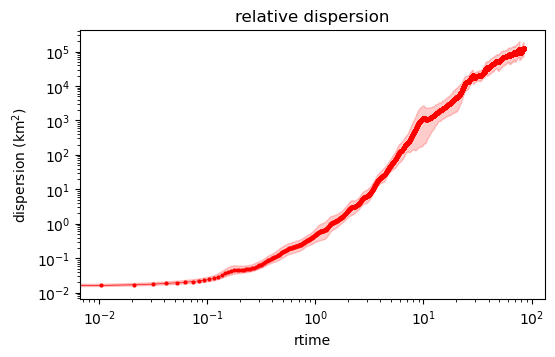

In [3]:
import matplotlib.pyplot as plt

r2m.plot.line(xscale='log', yscale='log', figsize=(6,3.5), marker='o', color='r', markersize=2, lw=0.5, zorder=1)
plt.fill_between(r2m.rtime, lower, upper, alpha=0.2, color='r', zorder=-5)
plt.title('relative dispersion')
plt.ylabel('rtime (day)')
_ = plt.ylabel('dispersion (km$^2$)')

#### 2.3 Get analytical predictions for dispersion

Analytical predictions for relative dispersion can be summarized into a table:

| wavenumber spectra | regimes | free parameters| predictions of relative dispersion |
| :----------------- | :-----: | :------------: | :--------------------------------: |
| $K^{-3}$ or steeper | nonlocal (Lundgren) | $T_L$ | $r_0^2 \exp\left(\frac{8t}{T_L}\right)$ |
| $K^{-2}$ | local (GM internal wave) | $\lambda$ | $3.28125\lambda^4 t^4$ (asymptotic) |
| $K^{-5/3}$ | local (Richardson) | $\beta$ | $5.2675\beta^3 t^3$ (asymptotic) |
| decorrelated | diffusive (Rayleigh) | $\kappa_2$ | $r_0^2 + 4\kappa_2 t$ |

Now we **guess** that the dispersion follows the Richardson's $t^3$ behavior.  We them calculate this behavior by adjusting some free parameters.

In [5]:
from xdispersion import ana_r2

# free parameters beta, k2, and r0 for different regimes
richardson = ana_r2(r2, params={'beta':0.4, 'r0':0.13},
                    regime='richardson-a')  # asymptotic Richardson prediciton (t^3)
diffusive  = ana_r2(r2, params={'k2':300  , 'r0':0.13},
                    regime='diffusive'   )  # diffusive or Rayleigh regime (t^1)

# one may also simply do this by: richardson = r2.rtime ** 3.0
# but we need to scale this to fit the curve, similar to adjusting the free parameter 'beta'
# This is only the asymptotic regime.  With 'r2_ana', we could get the full Richardson prediction

Plot the dispersion with analytical predictions

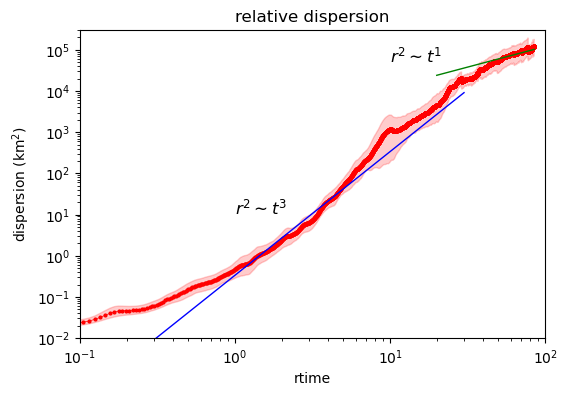

In [6]:
import matplotlib.pyplot as plt

richardson = richardson.sel(rtime=slice(0, 30)) # select 0-30 days
diffusive  =  diffusive.sel(rtime=slice(20, 100)) # select 20-100 days

r2m.plot.line(xscale='log', yscale='log', figsize=(6,4), marker='o', color='r', markersize=2, lw=0.5, zorder=1)
plt.plot(richardson.rtime, richardson, color='b', lw=1)
plt.plot(diffusive.rtime, diffusive, color='g', lw=1)
plt.fill_between(r2m.rtime, lower, upper, alpha=0.2, color='r', zorder=-5)
plt.xlim([1e-1, 1e2])
plt.ylim([1e-2, 3e5])
plt.text(1e0, 1e1, '$r^2\\sim t^3$', size=12)
plt.text(1e1, 5e4, '$r^2\\sim t^1$', size=12)
plt.title('relative dispersion')
plt.ylabel('rtime (day)')
_ = plt.ylabel('dispersion (km$^2$)')

It is clear that the intermediate dispersion behavior does not fully follow the Richardson's prediction $t^3$.  After about 40 days, diffusive behavior $t^1$ can be reached.

### 3. Conclusions

The analytical preditions can be calculated from those functions in `xdispersion.analytics`.  In these functions, `regime` is a keyword parameter.  With proper free parameters `params` for each regime, one may get an analytical predition as close as those observed scatters (in a least-square sense).  Then we could see if the dispersion behavior follows the expected prediction.